In [1729]:
!pip install jupyterthemes
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('grade3')

In [2270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

# Data Preprocessing

### Import Sentiment Data for Bitcoin

In [2314]:
#load dataset
df = pd.read_csv("cryptodata/btc_reddit.csv")
#Drop irrelevant columns
df = df.drop(['cryptoId','start','duration','open', 'high', 'low', 'source', 'count', 'average', 'std','negative','positive'], axis=1)

### Label the data according to their future 10 day price change

In [2315]:
#labeling function: 1=BUY, 0=HOLD, -1=SELL
def label(x):
    if x > 0.03: 
        return 2 #BUY
    elif x < -0.04: 
        return 0 #SELL`
    else:
        return 1 #HOLD

### Add new features 

In [2316]:
# Add the following feature columns:

#'7_day_score' = 7 day moving average of sentiment score
#'7_day_score_pct' = 7 day percentage change of score's moving average
df['7_day_score'] =  df['score'].rolling(window=7).mean()
df['7_day_score_pct'] = df['7_day_score'].pct_change(periods=7)

#'5_day_moving_average_pct_change'
#'20_day_moving_average_pct_change'
df['5_day_moving_average'] = df['close'].rolling(window=5).mean()
df['20_day_moving_average'] = df['close'].rolling(window=20).mean()
df['5_day_moving_average_pct_change'] = df['5_day_moving_average'].pct_change(periods=5)
df['20_day_moving_average_pct_change'] = df['5_day_moving_average'].pct_change(periods=20)

#Apply the labels
df['7_day_future_price_change'] = df['close'].pct_change(periods=-10)
df['label'] = df['7_day_future_price_change'].apply(label)

#Drop columns that won't be used as inputs
df = df.drop(['5_day_moving_average', '20_day_moving_average', 'close', '7_day_future_price_change'], axis=1)
#Drop nan values
df.dropna(inplace=True)

### FEATURES/INPUTS:
#### 1) VolumeUSD: Amount of USD traded at given day
#### 2) Score:  Sentiment score at given day
#### 3) 7_day_score	: 7 day moving average of score
#### 4) 7_day_score_pct	: 7 day percentage change of score (using moving average to calculate it to avoid noise
#### 5) 5_day_moving_average_pct_change: 5 day percantage change of price (calculated with 5 day MA)
#### 6) 20_day_moving_average_pct_change: 20 day percantage change of price (calculated with 20 day MA)
### TARGET/OUTPUT:
#### 0=SELL
#### 1=HOLD
#### 2=BUY

### Create Train/Test split and normalize input features

In [2386]:
dataloader = pd.DataFrame(df)

#splitting the data into input features and target label
features = dataloader.drop('label', axis=1)
target = dataloader['label']

In [2387]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target, 
                                        test_size=0.33, shuffle=True)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                        test_size=0.33, shuffle=True)

In [2388]:
#normalize X_train and X_test using StandarScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

### Visualize the class distribution in train/validation/test sets

In [2389]:
def get_class_distribution(obj):
    count_dict = {
        "BUY": 0,
        "HOLD": 0,
        "SELL": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['SELL'] += 1
        elif i == 1: 
            count_dict['HOLD'] += 1
        elif i == 2: 
            count_dict['BUY'] += 1
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

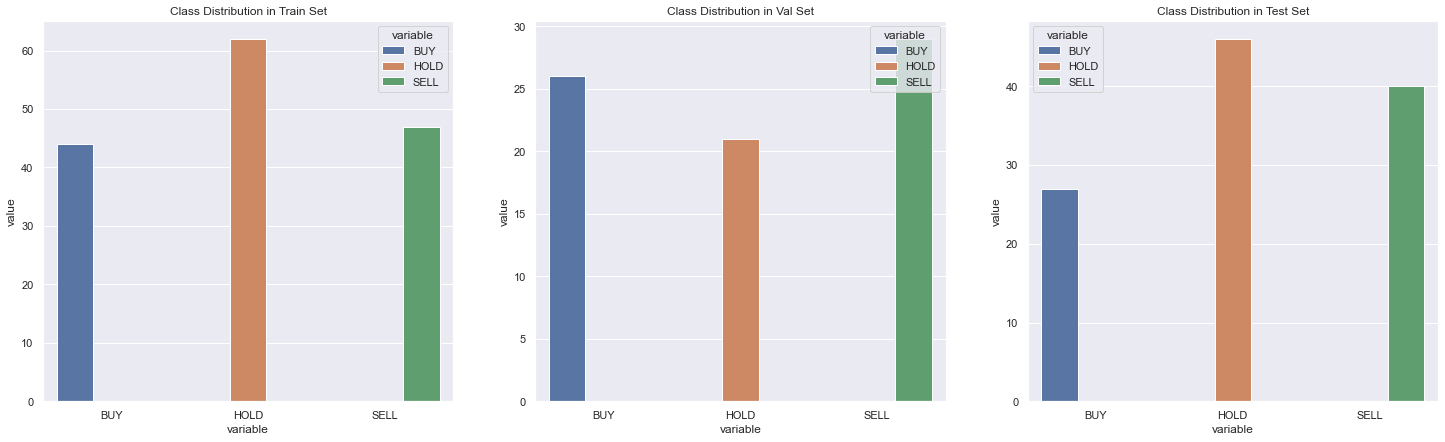

In [2390]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')

# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

# Neural Network

### Model Parameters

In [2391]:
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.002
NUM_FEATURES = 6
NUM_CLASSES = 3

### Custom Dataset

In [2392]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Dataloader

In [2393]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Define Neural Net Architecture

In [2394]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 100)
        self.layer_2 = nn.Linear(100, 100)
        self.layer_3 = nn.Linear(100, 100)
        self.layer_out = nn.Linear(100, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.batchnorm2 = nn.BatchNorm1d(100)
        self.batchnorm3 = nn.BatchNorm1d(100)   
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

In [2395]:
#setting device to gpu
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"

In [2396]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Train our model

In [2397]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [2398]:
# Define dictionaries to store accuracy/epoch and loss/epoch for trainset
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [2399]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad() 
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')



Begin training.


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.18368 | Val Loss: 1.09407 | Train Acc: 26.000| Val Acc: 34.211
Epoch 002: | Train Loss: 1.16120 | Val Loss: 1.09461 | Train Acc: 31.000| Val Acc: 34.211
Epoch 003: | Train Loss: 1.16513 | Val Loss: 1.09497 | Train Acc: 27.000| Val Acc: 31.579
Epoch 004: | Train Loss: 1.14135 | Val Loss: 1.09693 | Train Acc: 35.000| Val Acc: 31.579
Epoch 005: | Train Loss: 1.15441 | Val Loss: 1.09917 | Train Acc: 28.000| Val Acc: 28.947
Epoch 006: | Train Loss: 1.15051 | Val Loss: 1.09964 | Train Acc: 30.333| Val Acc: 30.263
Epoch 007: | Train Loss: 1.10731 | Val Loss: 1.09965 | Train Acc: 34.667| Val Acc: 34.211
Epoch 008: | Train Loss: 1.13396 | Val Loss: 1.10021 | Train Acc: 36.333| Val Acc: 34.211
Epoch 009: | Train Loss: 1.15387 | Val Loss: 1.09847 | Train Acc: 31.333| Val Acc: 28.947
Epoch 010: | Train Loss: 1.14670 | Val Loss: 1.09546 | Train Acc: 32.333| Val Acc: 34.211
Epoch 011: | Train Loss: 1.10505 | Val Loss: 1.09293 | Train Acc: 33.667| Val Acc: 34.211
Epoch 012:

Epoch 095: | Train Loss: 0.92062 | Val Loss: 1.00518 | Train Acc: 58.333| Val Acc: 43.421
Epoch 096: | Train Loss: 0.91326 | Val Loss: 1.00173 | Train Acc: 60.333| Val Acc: 43.421
Epoch 097: | Train Loss: 0.89952 | Val Loss: 1.00077 | Train Acc: 61.667| Val Acc: 44.737
Epoch 098: | Train Loss: 0.90566 | Val Loss: 1.00243 | Train Acc: 61.000| Val Acc: 44.737
Epoch 099: | Train Loss: 0.89722 | Val Loss: 1.00349 | Train Acc: 59.667| Val Acc: 44.737
Epoch 100: | Train Loss: 0.87264 | Val Loss: 1.00754 | Train Acc: 62.667| Val Acc: 43.421
Epoch 101: | Train Loss: 0.90183 | Val Loss: 1.00751 | Train Acc: 59.000| Val Acc: 43.421
Epoch 102: | Train Loss: 0.89181 | Val Loss: 1.00692 | Train Acc: 62.333| Val Acc: 43.421
Epoch 103: | Train Loss: 0.91966 | Val Loss: 1.00754 | Train Acc: 53.333| Val Acc: 42.105
Epoch 104: | Train Loss: 0.90844 | Val Loss: 1.00724 | Train Acc: 53.333| Val Acc: 43.421
Epoch 105: | Train Loss: 0.87252 | Val Loss: 1.00849 | Train Acc: 63.000| Val Acc: 43.421
Epoch 106:

Epoch 188: | Train Loss: 0.80376 | Val Loss: 0.99339 | Train Acc: 64.667| Val Acc: 44.737
Epoch 189: | Train Loss: 0.79188 | Val Loss: 0.99248 | Train Acc: 69.667| Val Acc: 44.737
Epoch 190: | Train Loss: 0.77812 | Val Loss: 0.99452 | Train Acc: 68.333| Val Acc: 46.053
Epoch 191: | Train Loss: 0.80258 | Val Loss: 0.99378 | Train Acc: 68.000| Val Acc: 46.053
Epoch 192: | Train Loss: 0.78609 | Val Loss: 0.99271 | Train Acc: 64.667| Val Acc: 46.053
Epoch 193: | Train Loss: 0.80121 | Val Loss: 0.98916 | Train Acc: 64.000| Val Acc: 46.053
Epoch 194: | Train Loss: 0.79846 | Val Loss: 0.98943 | Train Acc: 66.000| Val Acc: 46.053
Epoch 195: | Train Loss: 0.78743 | Val Loss: 0.99123 | Train Acc: 66.000| Val Acc: 46.053
Epoch 196: | Train Loss: 0.78957 | Val Loss: 0.99044 | Train Acc: 68.667| Val Acc: 46.053
Epoch 197: | Train Loss: 0.76621 | Val Loss: 0.99012 | Train Acc: 70.667| Val Acc: 46.053
Epoch 198: | Train Loss: 0.79447 | Val Loss: 0.99196 | Train Acc: 67.667| Val Acc: 46.053
Epoch 199:

Epoch 281: | Train Loss: 0.70899 | Val Loss: 0.99241 | Train Acc: 71.333| Val Acc: 51.316
Epoch 282: | Train Loss: 0.67190 | Val Loss: 0.99049 | Train Acc: 73.667| Val Acc: 51.316
Epoch 283: | Train Loss: 0.69899 | Val Loss: 0.99037 | Train Acc: 73.667| Val Acc: 51.316
Epoch 284: | Train Loss: 0.71243 | Val Loss: 0.99189 | Train Acc: 71.333| Val Acc: 51.316
Epoch 285: | Train Loss: 0.70560 | Val Loss: 0.99161 | Train Acc: 76.333| Val Acc: 51.316
Epoch 286: | Train Loss: 0.71550 | Val Loss: 0.99282 | Train Acc: 69.667| Val Acc: 51.316
Epoch 287: | Train Loss: 0.67640 | Val Loss: 0.98581 | Train Acc: 74.667| Val Acc: 50.000
Epoch 288: | Train Loss: 0.67935 | Val Loss: 0.98469 | Train Acc: 74.667| Val Acc: 51.316
Epoch 289: | Train Loss: 0.67441 | Val Loss: 0.98852 | Train Acc: 73.667| Val Acc: 51.316
Epoch 290: | Train Loss: 0.69455 | Val Loss: 0.98868 | Train Acc: 70.000| Val Acc: 51.316
Epoch 291: | Train Loss: 0.65216 | Val Loss: 0.99183 | Train Acc: 75.667| Val Acc: 51.316
Epoch 292:

Epoch 376: | Train Loss: 0.60898 | Val Loss: 0.99297 | Train Acc: 80.000| Val Acc: 50.000
Epoch 377: | Train Loss: 0.60345 | Val Loss: 0.99460 | Train Acc: 81.333| Val Acc: 51.316
Epoch 378: | Train Loss: 0.61539 | Val Loss: 0.99322 | Train Acc: 75.000| Val Acc: 52.632
Epoch 379: | Train Loss: 0.64217 | Val Loss: 0.99547 | Train Acc: 74.333| Val Acc: 50.000
Epoch 380: | Train Loss: 0.62119 | Val Loss: 0.99240 | Train Acc: 77.333| Val Acc: 53.947
Epoch 381: | Train Loss: 0.59238 | Val Loss: 0.99591 | Train Acc: 81.333| Val Acc: 51.316
Epoch 382: | Train Loss: 0.59633 | Val Loss: 0.99243 | Train Acc: 81.000| Val Acc: 53.947
Epoch 383: | Train Loss: 0.59406 | Val Loss: 0.99316 | Train Acc: 82.333| Val Acc: 53.947
Epoch 384: | Train Loss: 0.63306 | Val Loss: 0.99688 | Train Acc: 80.667| Val Acc: 50.000
Epoch 385: | Train Loss: 0.62885 | Val Loss: 1.00009 | Train Acc: 75.667| Val Acc: 50.000
Epoch 386: | Train Loss: 0.60199 | Val Loss: 0.99911 | Train Acc: 75.667| Val Acc: 50.000
Epoch 387:

Epoch 470: | Train Loss: 0.59572 | Val Loss: 0.98927 | Train Acc: 82.333| Val Acc: 52.632
Epoch 471: | Train Loss: 0.54719 | Val Loss: 0.99436 | Train Acc: 80.000| Val Acc: 52.632
Epoch 472: | Train Loss: 0.54664 | Val Loss: 0.99338 | Train Acc: 78.333| Val Acc: 52.632
Epoch 473: | Train Loss: 0.52958 | Val Loss: 0.99050 | Train Acc: 83.333| Val Acc: 52.632
Epoch 474: | Train Loss: 0.52781 | Val Loss: 0.99360 | Train Acc: 82.000| Val Acc: 52.632
Epoch 475: | Train Loss: 0.53379 | Val Loss: 0.99474 | Train Acc: 81.333| Val Acc: 52.632
Epoch 476: | Train Loss: 0.54704 | Val Loss: 0.99255 | Train Acc: 77.333| Val Acc: 52.632
Epoch 477: | Train Loss: 0.54466 | Val Loss: 0.99003 | Train Acc: 79.667| Val Acc: 52.632
Epoch 478: | Train Loss: 0.54722 | Val Loss: 0.99027 | Train Acc: 78.333| Val Acc: 52.632
Epoch 479: | Train Loss: 0.54708 | Val Loss: 0.98990 | Train Acc: 79.333| Val Acc: 52.632
Epoch 480: | Train Loss: 0.51413 | Val Loss: 0.98958 | Train Acc: 83.333| Val Acc: 52.632
Epoch 481:

# Visualize Loss and Accuracy

### Compare train and validation set learning curves

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

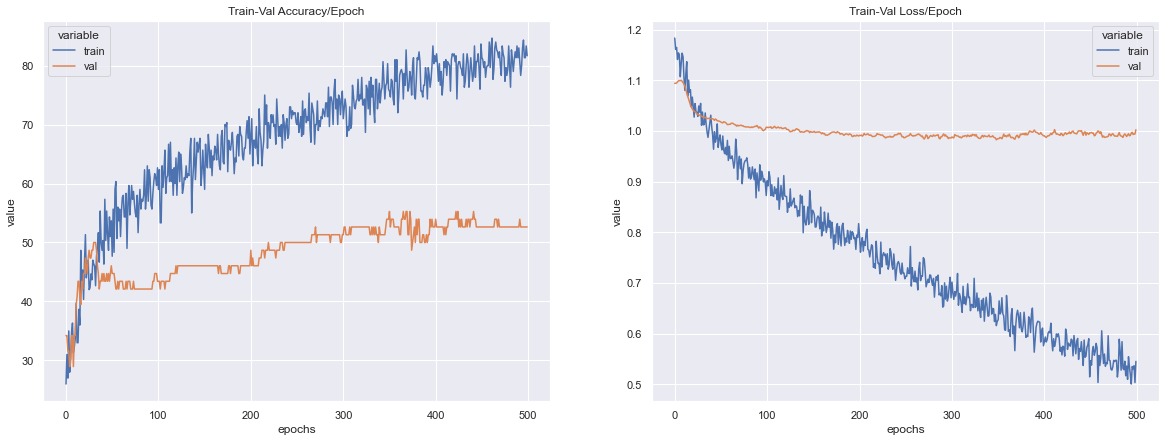

In [2400]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')


### Evaluate test results

In [2401]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [2402]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58        40
           1       0.56      0.50      0.53        46
           2       0.55      0.67      0.60        27

    accuracy                           0.57       113
   macro avg       0.57      0.58      0.57       113
weighted avg       0.57      0.57      0.56       113



<AxesSubplot:>

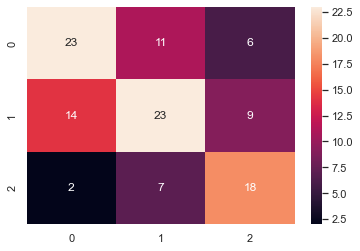

In [2403]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)